# softmax回归的简洁实现
:label:`sec_softmax_concise`

在 :numref:`sec_linear_concise` 中，我们可以发现(**通过深度学习框架的高级API能够使实现**)
(~~softmax~~)
线性(**回归变得更加容易**)。同样地，通过深度学习框架的高级API也能更方便地实现分类模型。让我们继续使用Fashion-MNIST数据集，并保持批量大小为256，就像在 :numref:`sec_softmax_scratch` 中一样。


In [ ]:
pip install -U d2l

     |████████████████████████████████| 83 kB 611 kB/s 


In [12]:
import torch
from torch import nn
from d2l import torch as d2l

In [13]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid poten

## 初始化模型参数

如我们在 :numref:`sec_softmax` 所述，[**softmax 回归的输出层是一个全连接层**]。因此，为了实现我们的模型，我们只需在 `Sequential` 中添加一个带有10个输出的全连接层。同样，在这里，`Sequential` 并不是必要的，但我们可能会形成这种习惯。因为在实现深度模型时，`Sequential`将无处不在。我们仍然以均值0和标准差0.01随机初始化权重。


In [14]:
# PyTorch不会隐式地调整输入的形状。因此，我们在线性层前定义了展平层（flatten），来调整网络输入的形状
# Flatten()将任何维度的tensor转化为2D的tensor
#当开始维度为0，最后维度为-1，展开为一维
#当开始维度为1，最后维度为-1，也就是说第一维度不变，后面的压缩
# Linear(784, 10)定义线性层，输入为784，输出为10
# nn.Sequential 一个时序容器，Modules会以他们传入的顺序被添加到容器中
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):

    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)#normal_正态分布
#apply()用途 当一个函数的参数存在于一个元组或者一个字典中，用来间接的调用这个函数，并将元组或者字典中的参数按照顺序传递给参数

net.apply(init_weights);#就是迭代里面的函数直到所有层结束


## 重新审视Softmax的实现
:label:`subsec_softmax-implementation-revisited`

在前面 :numref:`sec_softmax_scratch` 的例子中，我们计算了模型的输出，然后将此输出送入交叉熵损失。从数学上讲，这是一件完全合理的事情。然而，从计算角度来看，指数可能会造成数值稳定性问题。

回想一下，softmax函数 $\hat y_j = \frac{\exp(o_j)}{\sum_k \exp(o_k)}$，其中$\hat y_j$是预测的概率分布。$o_j$是未归一化的预测$\mathbf{o}$的第$j$个元素。如果$o_k$中的一些数值非常大，那么 $\exp(o_k)$ 可能大于数据类型容许的最大数字（即 *上溢*（overflow））。这将使分母或分子变为`inf`（无穷大），我们最后遇到的是0、`inf` 或 `nan`（不是数字）的 $\hat y_j$。在这些情况下，我们不能得到一个明确定义的交叉熵的返回值。

解决这个问题的一个技巧是，在继续softmax计算之前，先从所有$o_k$中减去$\max(o_k)$。你可以证明每个 $o_k$ 按常数进行的移动不会改变softmax的返回值。在减法和归一化步骤之后，可能有些 $o_j$ 具有较大的负值。由于精度受限， $\exp(o_j)$ 将有接近零的值，即 *下溢*（underflow）。这些值可能会四舍五入为零，使 $\hat y_j$ 为零，并且使得 $\log(\hat y_j)$ 的值为 `-inf`。反向传播几步后，我们可能会发现自己面对一屏幕可怕的`nan`结果。

尽管我们要计算指数函数，但我们最终在计算交叉熵损失时会取它们的对数。
通过将softmax和交叉熵结合在一起，可以避免反向传播过程中可能会困扰我们的数值稳定性问题。如下面的等式所示，我们避免计算$\exp(o_j)$，而可以直接使用$o_j$。因为$\log(\exp(\cdot))$被抵消了。

$$
\begin{aligned}
\log{(\hat y_j)} & = \log\left( \frac{\exp(o_j)}{\sum_k \exp(o_k)}\right) \\
& = \log{(\exp(o_j))}-\log{\left( \sum_k \exp(o_k) \right)} \\
& = o_j -\log{\left( \sum_k \exp(o_k) \right)}.
\end{aligned}
$$

我们也希望保留传统的softmax函数，以备我们需要评估通过模型输出的概率。
但是，我们没有将softmax概率传递到损失函数中，而是[**在交叉熵损失函数中传递未归一化的预测，并同时计算softmax及其对数**]，这是一件聪明的事情 ["LogSumExp技巧"](https://en.wikipedia.org/wiki/LogSumExp)。


In [15]:
loss = nn.CrossEntropyLoss()

## 优化算法

在这里，我们(**使用学习率为0.1的小批量随机梯度下降作为优化算法**)。这与我们在线性回归例子中的相同，这说明了优化器的普适性。


In [16]:
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

## 训练

接下来我们[**调用**] :numref:`sec_softmax_scratch` 中(~~之前~~)(**定义的训练函数来训练模型**)。


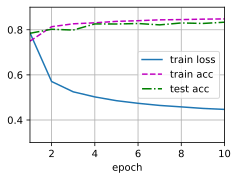

In [17]:
num_epochs = 10
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

和以前一样，这个算法收敛到一个相当高的精度，而且这次的代码行比以前少了。

## 小结

* 使用高级 API，我们可以更简洁地实现 softmax 回归。
* 从计算的角度来看，实现softmax回归比较复杂。在许多情况下，深度学习框架在这些著名的技巧之外采取了额外的预防措施，来确保数值的稳定性。这使我们避免了在实践中从零开始编写模型时可能遇到的陷阱。

## 练习

1. 尝试调整超参数，例如批量大小、迭代周期数和学习率，并查看结果。
1. 增加迭代周期的数量。为什么测试准确率会在一段时间后降低？我们怎么解决这个问题？


[Discussions](https://discuss.d2l.ai/t/1793)
